In [14]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import shap
import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import matthews_corrcoef, classification_report, roc_auc_score
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

<h1 style="text-align:center">Dataset Loading</h1>

In [15]:
def read_data():
    df = pd.read_csv("./input/telomere_health.csv")
    df = df.drop(
        columns=[
            "socioeconomic_status",
            "bp",
            "bmi_category",
            "hr_category",
            "rr_category",
            "health_condition",
            "education_cohort",
            "marital_status",
        ]
    )
    return df

<h1 style="text-align:center">Data Preprocessing</h1>

In [16]:
def categorical_to_numeric(df, column, mapping, regex=False):
    df[column] = df[column].replace(mapping, regex=regex)


def fill_na(df, column, default):
    fill_value = np.nan
    if default == "median":
        fill_value = df[column].median()
    elif default == "mode":
        fill_value = df[column].mode()[0]

    df[column] = df[column].fillna(fill_value)

In [17]:
def preprocess_data(df):

    categorical_to_numeric(
        df,
        "cigarette_smoking",
        {
            "No information": np.nan,
            "Former Smoker": np.nan,
            "Never Smoker": 0,
            "Occasional Smoker": 1,
            "Regular Smoker": 2,
        },
    )

    categorical_to_numeric(
        df,
        "physical_activity_cohort",
        {
            "No information": np.nan,
            "Sedentary (Inactive)": 0,
            "Minimally Active": 1,
            "Lightly Active": 2,
            "Moderately Active": 3,
            "Highly Active": 4,
        },
    )

    categorical_to_numeric(
        df,
        "alcohol_drinking",
        {
            "No information": np.nan,
            "Former Drinker": np.nan,
            "Never Drinker": 0,
            "Occasional Drinker": 1,
            "Moderate Drinker": 2,
            "Heavy Drinker": 3,
        },
    )

    categorical_to_numeric(
        df,
        "bp_category",
        {
            "No information": np.nan,
            "Hypotension (Low BP)": 0,
            "Normal BP": 1,
            "Elevated BP": 2,
            "Hypertension Stage 1": 3,
            "Hypertension Stage 2": 4,
            "Hypertensive Crisis": 5,
        },
    )

    categorical_to_numeric(
        df,
        "cardiovascular_disease_diagnosis",
        {
            "^No known*": 0,
            "^Non-cardiovascular*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "cancer_diagnosis",
        {
            "^Clinically Healthy*": 0,
            "^Non-oncologic*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "depression_anxiety_diagnosis",
        {
            "^No Known*": 0,
            "^Anxiety and/or*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "allergy_diagnosis",
        {
            "^No Diagnosed*": 0,
            "^Single.*": 1,
            "^Multi.*": 1,
        },
        regex=True,
    )

    categorical_to_numeric(
        df,
        "diabetes_diagnosis",
        {
            "^No known diagnosis*": 0,
            "^Diagnosed with*": 1,
        },
        regex=True,
    )

    df["hr"] = pd.to_numeric(df["hr"], errors="coerce")
    df["rr"] = pd.to_numeric(df["rr"], errors="coerce")

    fill_na(df, "hr", "median")
    fill_na(df, "rr", "median")
    fill_na(df, "bmi", "median")
    fill_na(df, "alcohol_drinking", "mode")
    fill_na(df, "cigarette_smoking", "mode")
    fill_na(df, "bp_category", "mode")
    fill_na(df, "physical_activity_cohort", "mode")

    df = pd.get_dummies(df, columns=["sex"])

    return df

<h1 style="text-align:center">Model Training</h1>

In [54]:
def train_model(df, to_predict, rs=0, vt=0.1):
    y = df.pop(to_predict)
    X = df

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=rs
    )

    # Feature Selection, Scaling and Training Pipeline
    pipeline = Pipeline(
        [
            ("selector", VarianceThreshold(threshold=vt)),
            ("scaler", StandardScaler()),
            ("lsvc", SVC(kernel="linear", probability=True, class_weight="balanced")),
        ]
    )

    # Training Model
    pipeline.fit(X_train, y_train)

    # Pipeline Partitioning
    selector = pipeline.named_steps["selector"]
    scaler = pipeline.named_steps["scaler"]
    lsvc_model = pipeline.named_steps["lsvc"]

    # Feature Variance, Weights
    selected_indeces = selector.get_support()

    features_names = pd.Series(X_train.columns[selected_indeces])
    feature_names = [name.replace("_", " ").upper() for name in features_names]

    feature_variances = pd.Series(selector.variances_[selected_indeces])
    feature_weights = pd.Series(pipeline.named_steps["lsvc"].coef_[0])

    feature_report = pd.DataFrame(
        data={
            "Selected Features": features_names,
            "Variances": feature_variances,
            "Weights": feature_weights,
        }
    )

    feature_report = feature_report.sort_values(by="Weights", key=abs, ascending=False)
    feature_report = feature_report.reset_index(drop=True)

    # Feature Shapley Values
    X_train_selected = selector.transform(X_train)
    X_train_transformed = scaler.transform(X_train_selected)

    X_test_transformed = selector.transform(X_test)
    X_test_transformed = scaler.transform(X_test_transformed)

    explainer = shap.LinearExplainer(lsvc_model, X_train_transformed)
    shap_values = explainer.shap_values(X_test_transformed)

    def shap_plot():
        shap.plots.violin(
            shap_values,
            features=X_test_transformed,
            feature_names=feature_names,
        )

    # Model Metrics
    y_pred = pipeline.predict(X_test)
    y_probs = lsvc_model.predict_proba(X_test_transformed)

    # Compute Cross-Validation Accuracy
    cv_scores = cross_val_score(pipeline, X_test, y_test, cv=5, scoring="accuracy")
    cv_accuracy = round(np.mean(cv_scores) * 100, 2)

    # Compute Matthew's Coefficient
    matthews_coeff = matthews_corrcoef(y_test, y_pred)
    matthews_coeff = round(matthews_coeff * 100, 2)

    # Test ROC-AUC
    auc_score = roc_auc_score(y_test, y_probs[:, 1])
    auc_score = round(auc_score * 100, 2)

    # Generate Classification Report
    model_report = classification_report(
        y_test, y_pred, target_names=["No Disease", "Disease"], output_dict=True
    )
    model_report = pd.DataFrame(model_report).drop("accuracy", axis=1).T.round(2)

    return (
        cv_accuracy,
        matthews_coeff,
        auc_score,
        feature_report,
        shap_plot,
        model_report,
    )

<h1 style="text-align:center">Cardiovascular Disease Prediction 🩺</h1>

In [19]:
cvd_df = read_data()
cvd_preprocessed = preprocess_data(cvd_df)


(
    cvd_cv_accuracy,
    cvd_matthews_coeff,
    cvd_auc_score,
    cvd_feature_report,
    cvd_shap_plot,
    cvd_model_report,
) = train_model(cvd_preprocessed, "cardiovascular_disease_diagnosis", 958784)

<h1 style="text-align:center">Features and Model Metrics</h1>

<h2>5-Fold Accuracy</h2>

In [20]:
print(f"5-Fold Cross-Validation Accuracy: {cvd_cv_accuracy}")

5-Fold Cross-Validation Accuracy: 86.99


<h2>Precission, Recall, F1 Scores</h2>

In [21]:
print(cvd_model_report)

              precision  recall  f1-score  support
No Disease         0.95    0.71      0.81    114.0
Disease            0.52    0.90      0.66     40.0
macro avg          0.74    0.81      0.74    154.0
weighted avg       0.84    0.76      0.77    154.0


<h2>Matthew's Coefficient </h2>

In [22]:
print(f"Matthew's Coefficient: {cvd_matthews_coeff}")

Matthew's Coefficient: 53.83


<h2>Area Under the Curve of the Receiver Operating Characteristic (ROC-AUC)</h2>

In [23]:
print(f"Test ROC-AUC: {cvd_auc_score}")

Test ROC-AUC: 90.35


<h2>Selected Features' Variances & Weights</h2>

In [24]:
cvd_feature_report

,Selected Features,Variances,Weights
0,age,334.872789,1.123468
1,bp_category,1.012738,0.560376
2,physical_activity_cohort,1.795531,-0.349204
3,depression_anxiety_diagnosis,0.105072,0.312897
4,telomere_length,69.070270,-0.215262
5,rr,3.791691,0.199055
6,cancer_diagnosis,0.146235,0.119923
7,alcohol_drinking,0.571068,0.069818
8,bmi,405.680758,-0.032934
9,cigarette_smoking,0.408082,-0.022970


<h2>Feature Shapley Values</h2>

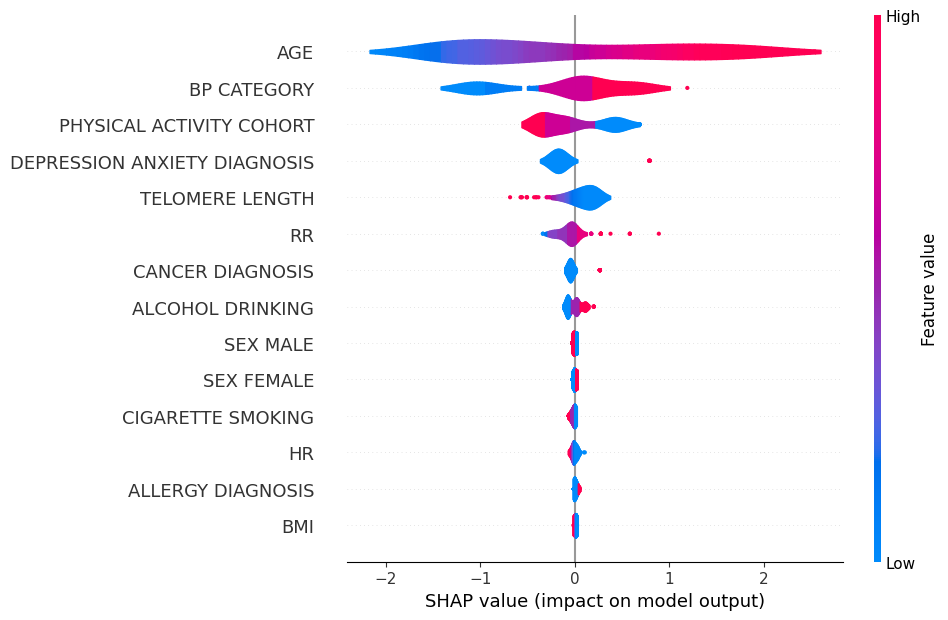

In [25]:
cvd_shap_plot()

<h1 style="text-align:center">Cancer Prediction 🎗</h1>

In [68]:
cancer_df = read_data()
cancer_preprocessed = preprocess_data(cancer_df)

(
    cancer_cv_accuracy,
    cancer_matthews_coeff,
    cancer_auc_score,
    cancer_feature_report,
    cancer_shap_plot,
    cancer_model_report,
) = train_model(cancer_preprocessed, "cancer_diagnosis", rs=397009, vt=0.1)

In [ ]:
import random

while True:
    cancer_df = read_data()
    cancer_preprocessed = preprocess_data(cancer_df)
    rs = random.randint(0, 1000000)
    (
        cancer_cv_accuracy,
        cancer_matthews_coeff,
        cancer_auc_score,
        cancer_feature_report,
        cancer_shap_plot,
        cancer_model_report,
    ) = train_model(cancer_preprocessed, "cancer_diagnosis", rs)

    print(cancer_cv_accuracy, rs)
    if cancer_cv_accuracy >= 90:
        break

<h1 style="text-align:center">Features and Model Metrics</h1>

<h2>10-Fold Accuracy</h2>

In [42]:
print(f"5-Fold Cross-Validation Accuracy: {cancer_cv_accuracy}")

5-Fold Cross-Validation Accuracy: 79.83


<h2>Precission, Recall, F1 Scores</h2>

In [43]:
print(cancer_model_report)

              precision  recall  f1-score  support
No Disease         0.93    0.58      0.71    133.0
Disease            0.21    0.71      0.33     21.0
macro avg          0.57    0.65      0.52    154.0
weighted avg       0.83    0.60      0.66    154.0


<h2>Matthew's Coefficient </h2>

In [46]:
print(f"Matthew's Coefficient: {cancer_matthews_coeff}")

Matthew's Coefficient: 20.19


<h2>Area Under the Curve of the Receiver Operating Characteristic (ROC-AUC)</h2>

In [47]:
print(f"Test ROC-AUC: {cancer_auc_score}")

Test ROC-AUC: 73.65


<h2>Selected Features' Variances & Weights</h2>

In [48]:
cancer_feature_report

,Selected Features,Variances,Weights
0,bmi,405.833481,-1.131092
1,bp_category,1.069937,0.634812
2,telomere_length,67.320220,0.393681
3,sex_Male,0.247618,-0.320008
4,sex_Female,0.247618,0.320008
5,alcohol_drinking,0.613351,0.256355
6,age,341.753333,0.137536
7,physical_activity_cohort,1.784840,-0.118592
8,hr,95.824695,-0.106791
9,cardiovascular_disease_diagnosis,0.196630,-0.087404


<h2>Feature Shapley Values</h2>

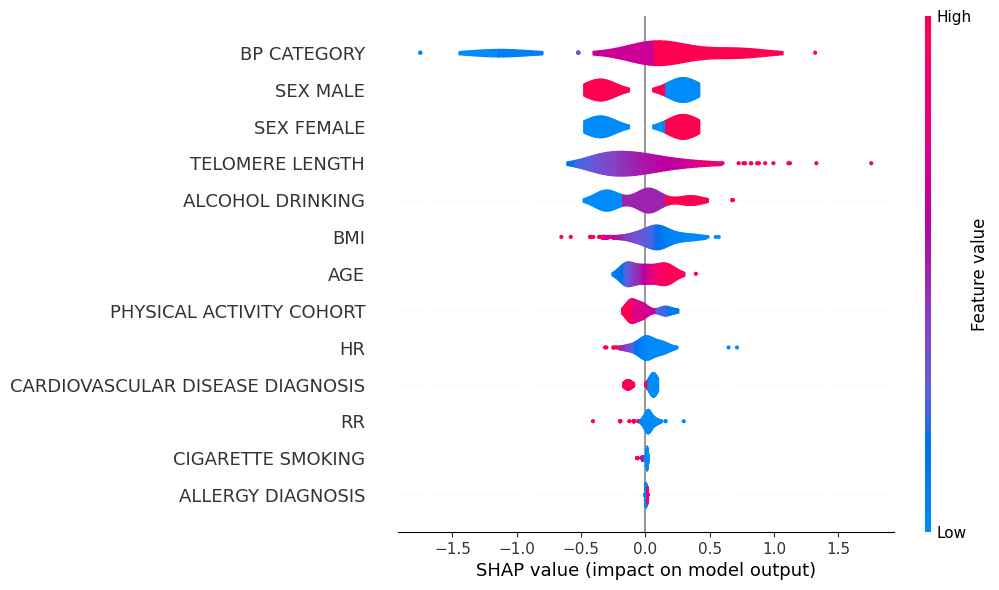

In [49]:
cancer_shap_plot()